# Predicting Cancer Type from Single Cell RNA-Seq Data

### Elsa Bismuth & Jonathan Mathews

Updated On: 11/24/2022

This program is designed to accept scRNA-seq Gene Expression Matrices as input and will output cancer type predictions based on a multi-class classification model.

Input must have same number of genes but can have varying number of individual cells per sample.

## Import Statements and Mount Data Location (Google Drive)

GC represents garbage collector, and is used to manually empty the main memory (RAM) to keep the VM from crashing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MODELDIR = "/content/drive/My Drive/ML4FG_Project/"
DATADIR = "/content/drive/My Drive/ML4FG_Project/Data"

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## From Dataloader code:

#### Common_Genes.txt

List of genes in common between all inputs to transform the data to have the same number of genes as well as the same genes themselves as attributes.

#### Train_Files.txt

List of gene expression files that are dedicated for training to help create a Dataloader for lessening burden on CPU.

#### Validation_Files.txt

List of gene expression files that are dedicated for validation to help create a Dataloader for lessening burden on CPU.

#### Test_Files.txt

List of gene expression files that are dedicated for testing to help create a Dataloader for lessening burden on CPU.

In [ ]:
genesToUse = []
with open(MODELDIR + "Common_Genes.txt") as f:

  numGenes = int(f.readline())
  for line in f:

    genesToUse.append(line.rstrip())

trainFiles = []
with open(MODELDIR + "Train_Files.txt") as f:

  for line in f:

    trainFiles.append(line.rstrip())

valFiles = []
with open(MODELDIR + "Validation_Files.txt") as f:

  for line in f:

    valFiles.append(line.rstrip())

testFiles = []
with open(MODELDIR + "Test_Files.txt") as f:

  for line in f:

    testFiles.append(line.rstrip())

## Creating Dataloader

The dataloader takes in a list of filenames to include in a certain dataset (train, validation, or test). Based on the filenames, it determines the cancer type and maps this to an integer in between 0 and the total number of classes (6 total classes with our example).

Reads in gene expression matrices and deletes any individual cell that includes non-numeric values (or values that cannot be cast to numeric types). These values cannot be imputed and must be removed **. Additionally, selects only the genes that all input matrices have in common, to make the data have the same number of genes and the same genes themselves.

Uses a batch size of 1 due to lack of data (only 84 samples). If more data is included, consider higher batch sizes to prevent overfitting.

__** NOTE: This can reduce the predictive power of the model, as the original cell type proportion is modified. However, we found for our purposes, it did not cause significant problems. If model does not converge properly, consider ways to impute these non-numeric values.**__



In [ ]:
class GeneExDataset(torch.utils.data.IterableDataset):

  def __init__(self, dataDir, fileNames, genes):

    super(GeneExDataset, self).__init__()

    self.DATADIR = dataDir
    self.fileNames = fileNames
    self.numerizeClass = {'AML': 0, 'CRC': 1, 'GBM': 2, 'LUAD': 3, 'MPAL': 4, 'PDAC': 5}
    self.genesUsed = genes
  
  def __iter__(self):

    for fileName in self.fileNames:

      data = pd.read_csv(os.path.join(self.DATADIR, fileName), sep = '\t').T
      data = data.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
      data = data[self.genesUsed].values.T

      cancerType = fileName.split('-')[0]

      yield(torch.tensor(data, dtype = torch.float), self.numerizeClass[cancerType])

      del data
      gc.collect()

In [ ]:
trainDataset = GeneExDataset(DATADIR, trainFiles, genesToUse)
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size = 1, num_workers = 0)

valDataset = GeneExDataset(DATADIR, valFiles, genesToUse)
valDataloader = torch.utils.data.DataLoader(valDataset, batch_size = 1, num_workers = 0)

testDataset = GeneExDataset(DATADIR, testFiles, genesToUse)
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size = 1, num_workers = 0)

## ENN Model Framework

Creating the ENN model framework and the feed-forwward algorithm. A dropout of 0.3 is used as regularization in all layers except the final output layer of the DNN section. This helps with generalization of the model and prevents overfitting.

Model framework is as follows:

Input $\rightarrow$ [N cells x 6865 genes]

CNN $\rightarrow$ [N cells x 100 features]

Average $\rightarrow$ [1 x 100 features] $=$ [100 features]

DNN Layer 1 $\rightarrow$ [64 features]

DNN Layer 2 $\rightarrow$ [16 features]

DNN Layer 3 $\rightarrow$ [6 classes] $=$ Output

In [ ]:
class ENN(nn.Module):

  def __init__(self, 
                inputChannel = numGenes,
                filterWidth = 1,
                outputChannels = 100,
                hiddenNeurons = [100, 64, 16],
                outputNeurons = 6,
                dropout = 0.3):
      
      super(ENN, self).__init__()
      
      self.convNet = nn.Sequential( nn.Conv1d(inputChannel, outputChannels, filterWidth, padding = 0),
                                    nn.Dropout2d(dropout),
                                    nn.ELU(inplace=True) )
      
      denseLayers = []
      for i in range(len(hiddenNeurons) - 1):

        denseLayers += [ nn.Linear(hiddenNeurons[i], hiddenNeurons[i + 1]),
                         nn.Dropout(dropout),
                         nn.ELU(inplace=True) ]
      
      denseLayers += [ nn.Linear(hiddenNeurons[-1], outputNeurons),
                       nn.Softmax(dim=1) ]

      self.denseNet = nn.Sequential(*denseLayers)

  def forward(self, x):

      net = self.convNet(x)
      net = torch.mean(net, dim = 2)
      net = self.denseNet(net)

      return(net)

## Epoch Protocol

Follow a normal protocol for a single epoch. If training, calculate gradient to update weights. If validation, just calculate loss and accuracy.

In [ ]:
def runOneEpoch(trainFlag, dataloader, enn, optimizer, device = 'cuda'):

  torch.set_grad_enabled(trainFlag)
  enn.train() if trainFlag else enn.eval()

  losses = []
  correctPred = 0
  totalPred = 0

  for (x, y) in dataloader:

    y = torch.tensor(keras.utils.to_categorical(y, num_classes = 6))
    y = y.squeeze()
    
    x = x.to(device)
    y = y.to(device)

    output = enn(x)
    output = output.squeeze()
    loss = F.binary_cross_entropy( output, y )

    if trainFlag:

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    losses.append(loss.detach().cpu().numpy())
    
    if torch.argmax(output).item() == torch.argmax(y).item():

      correctPred += 1
      totalPred += 1
    
    else:

      totalPred += 1
    
  return( np.mean(losses), correctPred/totalPred )

## Set Up Model Instance

Using Adam optimizer.

In [ ]:
ennModel = ENN()
ennModel.to(device)
optimizer = torch.optim.Adam(ennModel.parameters(), amsgrad = True)

## Create Epoch Loop

Runs training and validation for the model, specifying gradients needed for training and not needed for validation. Use validation loss to determine early stopping, with a patience of 5.

In [ ]:
trainAccs = []
valAccs = []
patience = 5
patienceCounter = patience
bestValLoss = np.inf
checkpoint = 'enn_checkpoint.pt'

for epoch in range(75):

  trainLoss, trainAcc = runOneEpoch(True, trainDataloader, ennModel, optimizer, device)
  print('Train Complete')
  valLoss, valAcc = runOneEpoch(False, valDataloader, ennModel, optimizer, device)
  print('Validation Complete')

  trainAccs.append(trainAcc)
  valAccs.append(valAcc)

  if valLoss < bestValLoss:

    torch.save(ennModel.state_dict(), checkpoint)
    bestValLoss = valLoss
    patienceCounter = patience

  else:

    patienceCounter -= 1
    if patienceCounter <= 0:

      ennModel.load_state_dict(torch.load(checkpoint))
      break
    
  print('Epoch %i: Train loss = %.4f acc = %.4f, Validation loss = %.4f acc = %.4f, Patience left = %i' %
        (epoch + 1, trainLoss, trainAcc, valLoss, valAcc, patienceCounter))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "
/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/fetch.py:32: DtypeWarning: Columns (1,3,4,5,7,8,9,10,11,13,16,18,19,21,24,28,29,31,32,33,36,37,38,39,40,43,45,46,47,50,51,52,54,55,56,57,58,59,60,61,62,63,65,66,67,68,69,71,72,73,74,76,77,80,81,85,86,88,89,91,92,96,97,98,99,100,101,104,105,107,108,109,111,112,114,115,116,117,118,121,122,123,124,125,126,128,130,131,132,136,137,138,140,141,144,145,146,147,148,149,150,

Train Complete


/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/fetch.py:32: DtypeWarning: Columns (1,4,5,7,8,9,10,11,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,55,56,58,59,60,61,62,63,65,66,67,68,69,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87,88,91,92,94,95,96,97,99,100,101,102,103,104,105,106,107,109,110,111,112,113,114,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,148,150,152,153,154,155,156,157,158,159,160,161,162,164,166,168,169,170,171,172,173,174,175,176,177,178,179,181,182,183,184,186,188,189,190,191,193,194,195,196,197,199,200,201,202,203,204,205,206,207,208,209,212,213,214,215,217,218,219,220,221,222,224,225,226,229,231,232,233,235,237,238,239,240,243,244,245,246,247,248,249,250,251,252,253,254,256,257,258,259,261,262,263,264,265,266,267,271,273,274,275,276,279,280,281,282,286,287,288,292,293,294,297,298,299,300,302,303,304,305,308,309,3

Validation Complete
Epoch 1: Train loss = 0.4874 acc = 0.1190, Validation loss = 0.4507 acc = 0.1905, Patience left = 5
Train Complete
Validation Complete
Epoch 2: Train loss = 0.4666 acc = 0.1429, Validation loss = 0.4273 acc = 0.2857, Patience left = 5
Train Complete
Validation Complete
Epoch 3: Train loss = 0.4152 acc = 0.3095, Validation loss = 0.4199 acc = 0.3333, Patience left = 5
Train Complete
Validation Complete
Epoch 4: Train loss = 0.4351 acc = 0.2857, Validation loss = 0.3925 acc = 0.6190, Patience left = 5
Train Complete
Validation Complete
Epoch 5: Train loss = 0.3821 acc = 0.4524, Validation loss = 0.3428 acc = 0.6667, Patience left = 5
Train Complete
Validation Complete
Epoch 6: Train loss = 0.3981 acc = 0.3571, Validation loss = 0.3204 acc = 0.4762, Patience left = 5
Train Complete
Validation Complete
Epoch 7: Train loss = 0.3361 acc = 0.4762, Validation loss = 0.2801 acc = 0.5714, Patience left = 5
Train Complete
Validation Complete
Epoch 8: Train loss = 0.2893 acc = 

## Plotting Train and Validation Results

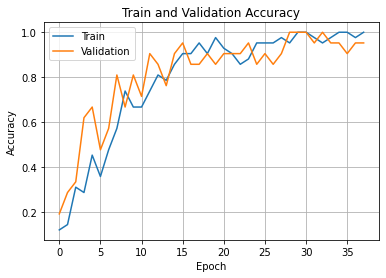

In [ ]:
plt.plot(trainAccs, label = 'Train')
plt.plot(valAccs, label = 'Validation')
plt.legend()
plt.grid(which = 'both')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.savefig(MODELDIR + 'Figures/Train_Validation_Accuracies.png')

## Test Model on Unseen Data

In [ ]:
testLoss, testAcc = runOneEpoch(False, testDataloader, ennModel, optimizer, device)
print('Test Accuracy = %.4f' % (testAcc))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/fetch.py:32: DtypeWarning: Columns (1,4,5,6,7,8,9,12,15,16,17,18,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,38,39,40,42,43,44,46,48,49,50,51,52,53,55,57,58,59,61,63,64,66,67,69,70,72,73,74,77,78,79,80,81,82,83,84,85,86,88,89,90,91,92,93,94,95,96,97,98,99,100,101,103,104,105,106,108,109,110,112,113,114,116,118,119,121,122,125,126,127,128,131,132,133,134,137,139,140,141,142,143,144,146,147,148,149,150,151,153,154,155,157,160,161,162,164,165,167,168,169,170,171,172,174,176,177,178,179,180,181,186,187,188,190,191,194,195,196,197,198,200,201,202,203,204,205,207,208,209,210,211,213,216,217,218,219,220,221,222,223,225,226,227,228,229,231,232,233,234,235,237,238,239,240,241,245,246,248,250,251,252,254,257,258,259,264,265,266,268,269,270,271,272,273,274,275,276,277,278,279,280,281,283,284,285,286,287,288,290,292,293,294,297,298,299,303,304,305,306,307,308,309,310,312,313,314,315,316,318,321,323,324,325,326,327,329,330,331,332,3

Test Accuracy = 0.9524


## Saliency Maps

Calculate saliency maps for training, validation, and testing data to find most impactful genes for cancer type prediction.

Find impactful genes per cancer type. This is done by averaging the saliency maps across cancer type.

In [ ]:
torch.set_grad_enabled(True)
saliencyDict = {}

trainDataset = GeneExDataset(DATADIR, trainFiles, genesToUse)
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size = 1, num_workers = 0)

valDataset = GeneExDataset(DATADIR, valFiles, genesToUse)
valDataloader = torch.utils.data.DataLoader(valDataset, batch_size = 1, num_workers = 0)

testDataset = GeneExDataset(DATADIR, testFiles, genesToUse)
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size = 1, num_workers = 0)

In [ ]:
for (x, y) in trainDataloader:

  xGpu = x.to(device)
  xGpu.requires_grad_()

  output = ennModel(xGpu).squeeze()

  dummy = torch.ones_like(output)
  output.backward(dummy)

  gradient = xGpu.grad.detach().cpu().numpy()
  output = output.detach().cpu().numpy()

  saliency = gradient * x.detach().numpy()
  label = y.item()

  if label in saliencyDict:

    saliencyDict[label] = (saliencyDict[label] + np.mean(saliency, axis = 2)) / 2

  else:

    saliencyDict[label] = np.mean(saliency, axis = 2)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "
/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/fetch.py:32: DtypeWarning: Columns (1,3,4,5,7,8,9,10,11,13,16,18,19,21,24,28,29,31,32,33,36,37,38,39,40,43,45,46,47,50,51,52,54,55,56,57,58,59,60,61,62,63,65,66,67,68,69,71,72,73,74,76,77,80,81,85,86,88,89,91,92,96,97,98,99,100,101,104,105,107,108,109,111,112,114,115,116,117,118,121,122,123,124,125,126,128,130,131,132,136,137,138,140,141,144,145,146,147,148,149,150,

In [ ]:
for (x, y) in valDataloader:

  xGpu = x.to(device)
  xGpu.requires_grad_()

  output = ennModel(xGpu).squeeze()

  dummy = torch.ones_like(output)
  output.backward(dummy)

  gradient = xGpu.grad.detach().cpu().numpy()
  output = output.detach().cpu().numpy()

  saliency = gradient * x.detach().numpy()
  label = y.item()

  if label in saliencyDict:

    saliencyDict[label] = (saliencyDict[label] + np.mean(saliency, axis = 2)) / 2

  else:

    saliencyDict[label] = np.mean(saliency, axis = 2)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/fetch.py:32: DtypeWarning: Columns (1,4,5,7,8,9,10,11,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,55,56,58,59,60,61,62,63,65,66,67,68,69,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87,88,91,92,94,95,96,97,99,100,101,102,103,104,105,106,107,109,110,111,112,113,114,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,148,150,152,153,154,155,156,157,158,159,160,161,162,164,166,168,169,170,171,172,173,174,175,176,177,178,179,181,182,183,184,186,188,189,190,191,193,194,195,196,197,199,200,201,202,203,204,205,206,207,208,209,212,213,214,215,217,218,219,220,221,222,224,225,226,229,231,232,233,235,237,238,239,240,243,244,245,246,247,248,249,250,251,252,253,254,256,257,258,259,261,262,263,264,265,266,267,271,273,274,275,276,279,280,281,282,286,287,288,292,293,294,297,298,299,300,302,303,304,305,308,309,3

In [ ]:
for (x, y) in testDataloader:

  xGpu = x.to(device)
  xGpu.requires_grad_()

  output = ennModel(xGpu).squeeze()

  dummy = torch.ones_like(output)
  output.backward(dummy)

  gradient = xGpu.grad.detach().cpu().numpy()
  output = output.detach().cpu().numpy()

  saliency = gradient * x.detach().numpy()
  label = y.item()

  if label in saliencyDict:

    saliencyDict[label] = (saliencyDict[label] + np.mean(saliency, axis = 2)) / 2

  else:

    saliencyDict[label] = np.mean(saliency, axis = 2)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/fetch.py:32: DtypeWarning: Columns (1,4,5,6,7,8,9,12,15,16,17,18,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,38,39,40,42,43,44,46,48,49,50,51,52,53,55,57,58,59,61,63,64,66,67,69,70,72,73,74,77,78,79,80,81,82,83,84,85,86,88,89,90,91,92,93,94,95,96,97,98,99,100,101,103,104,105,106,108,109,110,112,113,114,116,118,119,121,122,125,126,127,128,131,132,133,134,137,139,140,141,142,143,144,146,147,148,149,150,151,153,154,155,157,160,161,162,164,165,167,168,169,170,171,172,174,176,177,178,179,180,181,186,187,188,190,191,194,195,196,197,198,200,201,202,203,204,205,207,208,209,210,211,213,216,217,218,219,220,221,222,223,225,226,227,228,229,231,232,233,234,235,237,238,239,240,241,245,246,248,250,251,252,254,257,258,259,264,265,266,268,269,270,271,272,273,274,275,276,277,278,279,280,281,283,284,285,286,287,288,290,292,293,294,297,298,299,303,304,305,306,307,308,309,310,312,313,314,315,316,318,321,323,324,325,326,327,329,330,331,332,3

## Top Ten Most Impactful Genes per Cancer Type

We limit the output of the saliency maps to find the ten most impactful genes per cancer types. Then use a bar graph to show the relative impactfulness of these ten genes per cancer type. **

__** NOTE: There is not enough data (84 samples) to generalize gene impactfulness for cancer type predictions and draw actual conclusions. However, these results can be used as preliminary findings to help confirm later results when more data is used. **__

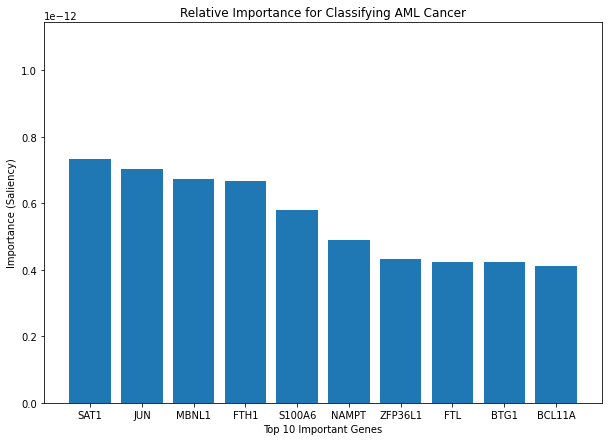

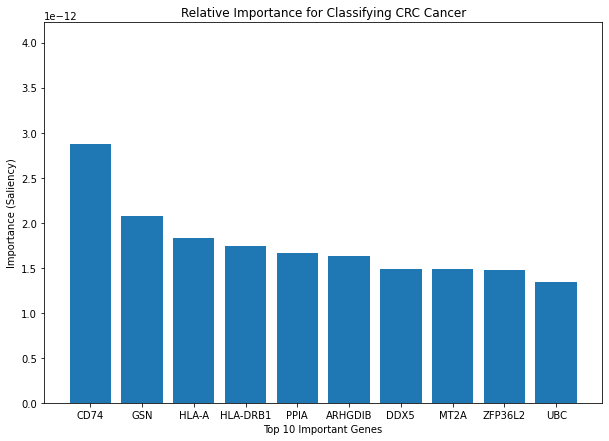

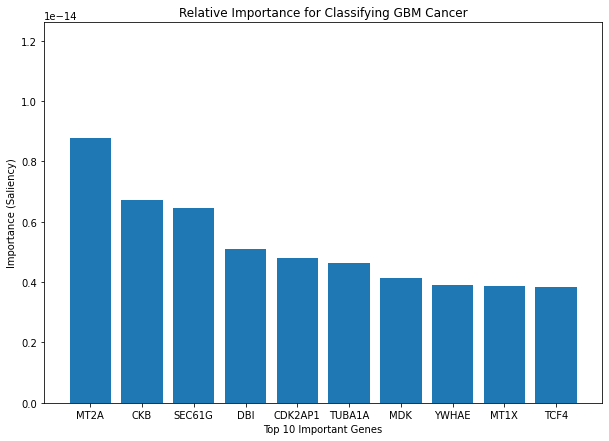

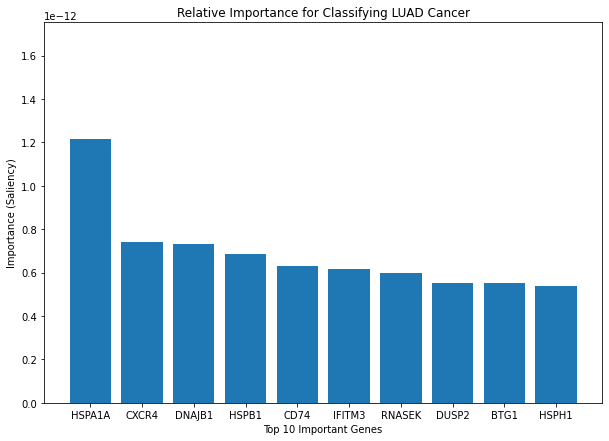

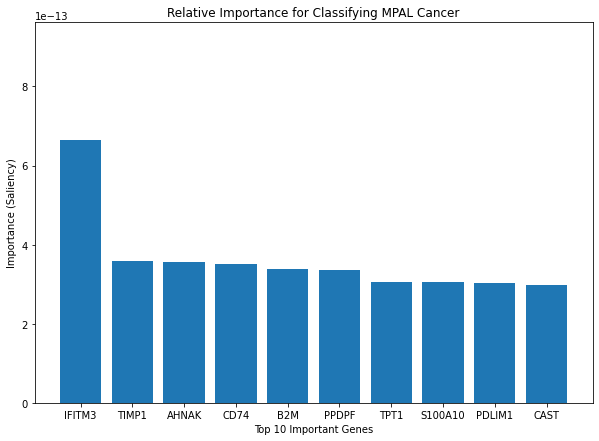

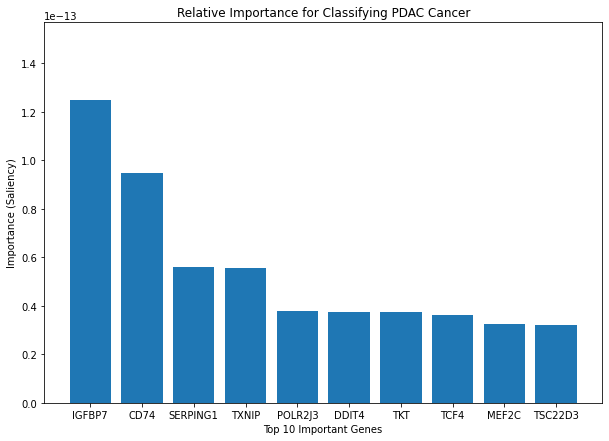

In [ ]:
classDict = {0: 'AML', 1: 'CRC', 2: 'GBM', 3: 'LUAD', 4: 'MPAL', 5: 'PDAC'}

with open(MODELDIR + 'Important_Features_Saliency.txt', 'w') as f:

  for label in range(6):

    f.write('%s\n' % classDict[label])

    saliency = np.squeeze(saliencyDict[label])
    impFeatureInd = np.argsort(saliency)[::-1][:10]
    top10Features = [genesToUse[i] for i in impFeatureInd]
    top10Saliency = [saliency[i] for i in impFeatureInd]

    for feature in top10Features:

      f.write('%s\n' % feature)
    
    f.write('\n')

    plt.figure(label, figsize = (10, 7))

    plt.bar(top10Features, top10Saliency)
    plt.ylim(0, top10Saliency[0] + top10Saliency[-1])

    plt.xlabel('Top 10 Important Genes')
    plt.ylabel('Importance (Saliency)')
    plt.title('Relative Importance for Classifying ' + classDict[label] + ' Cancer')

    plt.savefig(MODELDIR + 'Figures/' + classDict[label] + '_Top_Ten_Features.png')
    plt.show()